In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
from scipy.interpolate import splprep, splev
import time

Next steps:

1. Try curving these lines
2. Get an axial slice
3. Omit single point lines
4. circle-cylinder-circle

Comments as of Jan 29, 2024
1. ~1 hour to generate 30 fibers with max length of 30


False

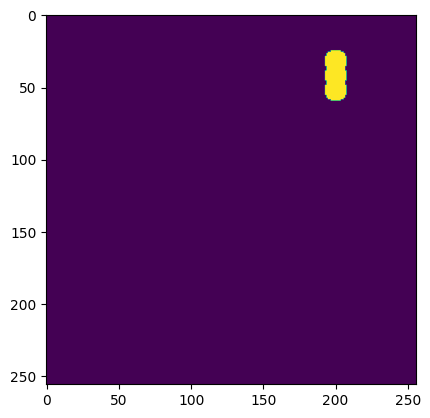

In [6]:
'''
Snip code from Daan: Making of voxel-based spheres
'''

cx, cy, cz = np.mgrid[-1:1:17j,-1:1:17j,-1:1:17j]
sphere_template = cx**2+cy**2+cz**2<1
plt.imshow(sphere_template[sphere_template.shape[0]//2])

volume = np.zeros((256,256,256))
volume[128-8:128+9, 32-8:32+9, 200-8:200+9] += sphere_template
volume[128-8:128+9, 32+10-8:32+10+9, 200-8:200+9] += sphere_template
volume[128-8:128+9, 32+20-8:32+20+9, 200-8:200+9] += sphere_template
volume[volume>1]=1

plt.imshow(volume[128])

volume[200-8:200+9, 32+20-8:32+20+9, 200-8:200+9][sphere_template].max()==1

# Straight Fibers

In [7]:
def is_within_bounds(point, volume, radius=1):
    x, y, z = point
    return radius <= x < volume.shape[0] - radius and radius <= y < volume.shape[1] - radius and radius <= z < volume.shape[2] - radius

def can_place_sphere(center, volume, radius=1):
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                if x**2 + y**2 + z**2 <= radius**2:
                    ix, iy, iz = center[0] + x, center[1] + y, center[2] + z
                    if not is_within_bounds((ix, iy, iz), volume, 0) or volume[ix, iy, iz] == 1:
                        return False
    return True

def generate_3d_fiber(volume, min_length=50, max_length=100, radius=2):
    
    attempts = 0
    max_attempts = 1000
    while attempts < max_attempts:
        center_point = np.array([random.randint(radius, dim - radius - 1) for dim in volume.shape])
        if can_place_sphere(center_point, volume, radius):
            break
        attempts += 1
    if attempts == max_attempts:
        return None

    fiber = [center_point]
    direction_choices = [
        [1, 0, 0], [0, 1, 0], [0, 0, 1],
        [-1, 0, 0], [0, -1, 0], [0, 0, -1],
        [1, 1, 0], [1, 0, 1], [0, 1, 1],
        [-1, -1, 0], [-1, 0, -1], [0, -1, -1],
        [1, -1, 0], [1, 0, -1], [0, 1, -1],
        [-1, 1, 0], [-1, 0, 1], [0, -1, 1]
    ]
    direction = np.array(random.choice(direction_choices))

    step_size = radius / 6  

    alternate_count = 1
    alternate_direction = 1

    while True:
        next_point = center_point + direction * step_size * alternate_count * alternate_direction
        next_point_int = np.round(next_point).astype(int)

        if not is_within_bounds(next_point_int, volume, radius) or not can_place_sphere(next_point_int, volume, radius):
            if len(fiber) >= min_length:
                return fiber
            else:
                return None

        fiber.append(next_point_int)

        
        alternate_direction *= -1
        if alternate_direction > 0:
            alternate_count += 1

        if len(fiber) >= max_length:
            return fiber


def add_voxel_sphere_to_volume(volume, center, radius=1):
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                if x**2 + y**2 + z**2 <= radius**2 and is_within_bounds((center[0]+x, center[1]+y, center[2]+z), volume, 0):
                    volume[center[0]+x, center[1]+y, center[2]+z] = 1

def update_volume_with_fiber(volume, fiber, radius=1):
    for point in fiber:
        add_voxel_sphere_to_volume(volume, point, radius)

def plot_fiber(ax, fiber, color='b'):
    for point in fiber:
        x, y, z = point
        ax.scatter(x, y, z, color=color, alpha=0.5)

def generate_and_count_fibers(volume, num_fibers, min_length=50, max_length=100, radius=12):
    successful_fibers = 0
    fibers = []
    total_attempts = 0
    max_total_attempts = 10000  # Set a limit on the total number of attempts to avoid infinite loops
    
    colors = plt.cm.jet(np.linspace(0,1,num_fibers))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    while successful_fibers < num_fibers and total_attempts < max_total_attempts:
        fiber = generate_3d_fiber(volume, min_length, max_length, radius)
        if fiber is not None:
            update_volume_with_fiber(volume, fiber, radius)
            plot_fiber(ax, fiber, color=colors[successful_fibers])  # Use successful_fibers as index to ensure unique colors
            ax.set_xlabel("X axis")
            ax.set_ylabel("Y axis")
            ax.set_zlabel("Z axis")
            fibers.append(fiber)
            successful_fibers += 1
        total_attempts += 1

    if successful_fibers < num_fibers:
        print(f"Warning: Only able to place {successful_fibers} fibers after {total_attempts} attempts.")

    return successful_fibers, fibers

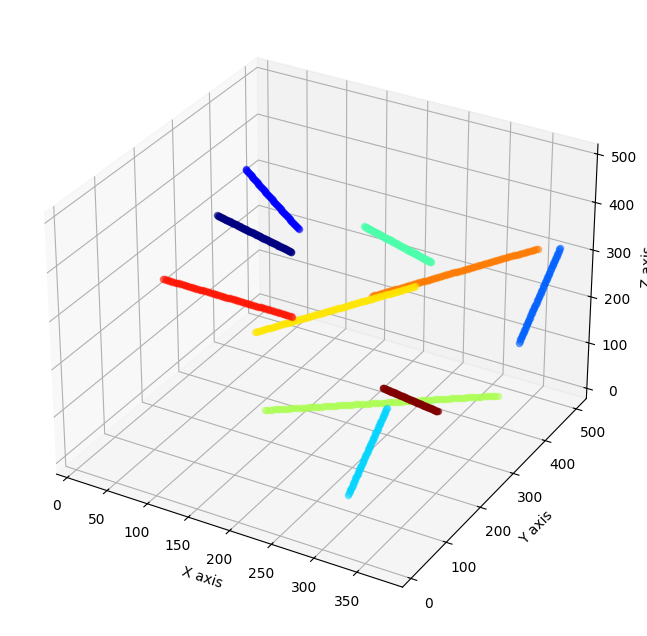

Number of successfully generated fibers: 10
--- 25.641632795333862 seconds ---


In [8]:
start_time = time.time()

volume_dimensions = [512, 512, 512]
volume = np.zeros(volume_dimensions)
num_fibers = 10

num_successful_fibers, fibers = generate_and_count_fibers(volume, num_fibers)

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# for fiber in fibers:
#     plot_fiber(ax, fiber)


plt.show()

print(f"Number of successfully generated fibers: {num_successful_fibers}")

print("--- %s seconds ---" % (time.time() - start_time))

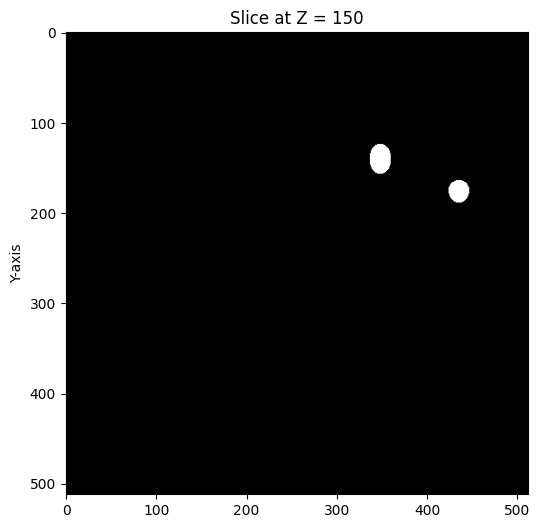

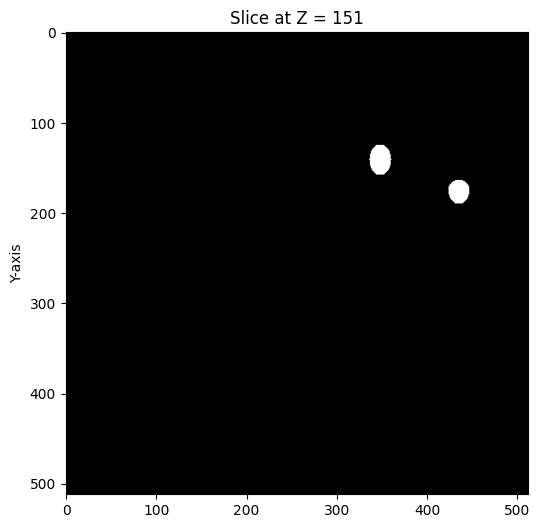

In [9]:
for z in range(150, 152):
    plt.figure(figsize=(6, 6))
    plt.imshow(volume[:,:, z], cmap='gray') 
    plt.title(f'Slice at Z = {z}')
    plt.ylabel('Y-axis')
    plt.show()

# Sinusoidal Fibers

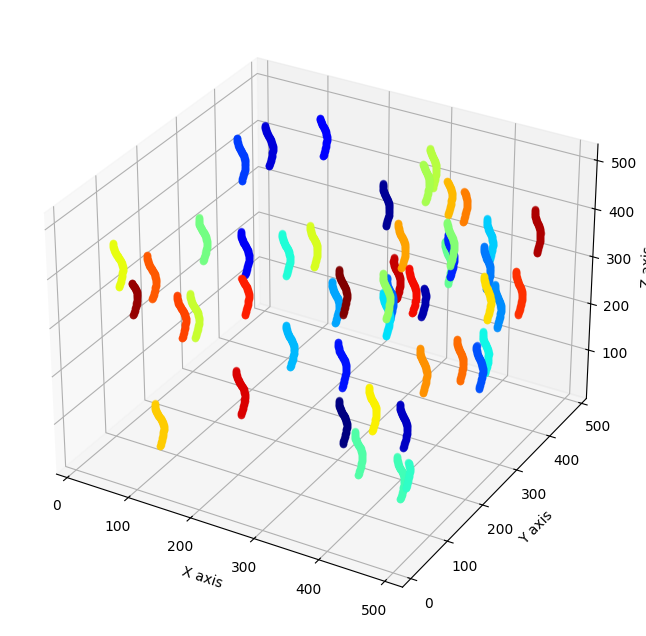

In [10]:
import numpy as np
import random


def is_within_bounds(point, volume, radius):
    for dim in range(3):
        if point[dim] - radius < 0 or point[dim] + radius >= volume.shape[dim]:
            return False
    return True

def can_place_sphere(center, volume, radius=1):
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                if x**2 + y**2 + z**2 <= radius**2:
                    ix, iy, iz = center[0] + x, center[1] + y, center[2] + z
                    if not is_within_bounds((ix, iy, iz), volume, 0) or volume[ix, iy, iz] == 1:
                        return False
    return True


def generate_3d_fiber(volume, min_length=400, max_length=500, radius=2, orientation='yz'):
    attempts = 0
    max_attempts = 1000
    while attempts < max_attempts:
        center_point = np.array([random.randint(radius, dim - radius - 1) for dim in volume.shape])
        if can_place_sphere(center_point, volume, radius):
            break
        attempts += 1
    if attempts == max_attempts:
        return None

    fiber = [center_point.tolist()]
    amplitude = 10
    frequency = 0.05
    step = 0
    while len(fiber) < max_length and step < max_length:
        sine_offset = amplitude * np.sin(frequency * step)
        if orientation == 'xy':
            next_point = center_point + np.array([sine_offset, step, 0])
        elif orientation == 'xz':
            next_point = center_point + np.array([sine_offset, 0, step])
        elif orientation == 'yz':
            next_point = center_point + np.array([0, sine_offset, step])
        else:
            raise ValueError("Unsupported orientation")

        next_point_rounded = np.round(next_point).astype(int)
        if not is_within_bounds(next_point_rounded, volume, radius):
            if len(fiber) < min_length:
                return None
            break  

        if not can_place_sphere(next_point_rounded, volume, radius):
            if len(fiber) < min_length:
                return None  
            break

        fiber.append(next_point_rounded.tolist())
        step += 1

    if len(fiber) < min_length:
        return None 

    return fiber

volume_dimensions = [512, 512, 512]
volume = np.zeros(volume_dimensions)
num_fibers = 50

num_successful_fibers, fibers = generate_and_count_fibers(volume, num_fibers)


plt.show()


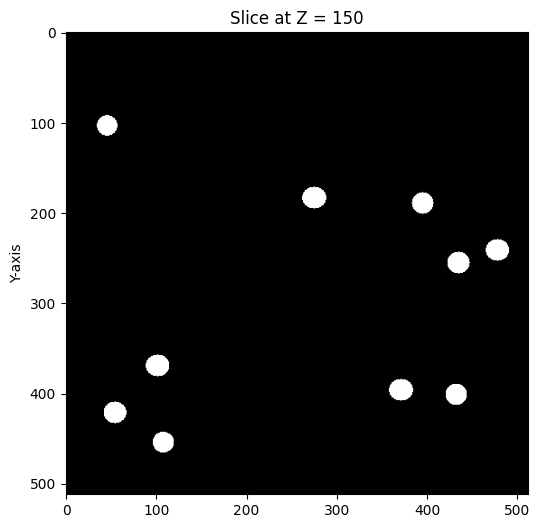

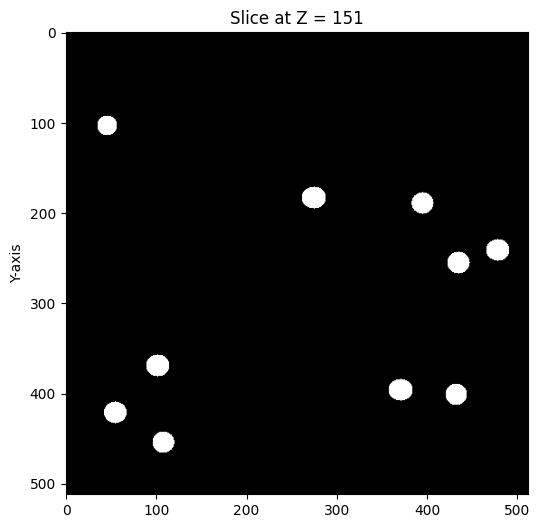

In [11]:
for z in range(150, 152):
    plt.figure(figsize=(6, 6))
    plt.imshow(volume[:,:, z], cmap='gray') 
    plt.title(f'Slice at Z = {z}')
    plt.ylabel('Y-axis')
    plt.show()

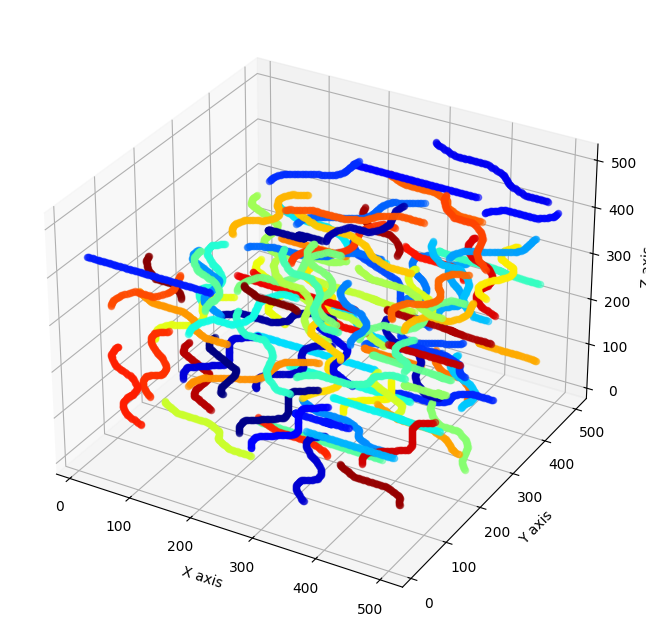

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def is_within_bounds(point, volume, radius=1):
    x, y, z = point
    return radius <= x < volume.shape[0] - radius and radius <= y < volume.shape[1] - radius and radius <= z < volume.shape[2] - radius

def can_place_sphere(center, volume, radius=1):
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                if x**2 + y**2 + z**2 <= radius**2:
                    ix, iy, iz = center[0] + x, center[1] + y, center[2] + z
                    if not is_within_bounds((ix, iy, iz), volume, 0) or volume[ix, iy, iz] == 1:
                        return False
    return True

def generate_3d_fiber(volume, min_length=50, max_length=100, radius=2, 
                      curve_amplitude=0.1, curve_frequency=0.1):
    attempts = 0
    max_attempts = 1000
    while attempts < max_attempts:
        center_point = np.array([random.randint(radius, dim - radius - 1) for dim in volume.shape])
        if can_place_sphere(center_point, volume, radius):
            break
        attempts += 1
    if attempts == max_attempts:
        return None

    fiber = [center_point]
    direction_choices = [
        np.array(choice) for choice in [[1, 0, 0], [0, 1, 0], [0, 0, 1],
                                        [-1, 0, 0], [0, -1, 0], [0, 0, -1],
                                        [1, 1, 0], [1, 0, 1], [0, 1, 1],
                                        [-1, -1, 0], [-1, 0, -1], [0, -1, -1],
                                        [1, -1, 0], [1, 0, -1], [0, 1, -1],
                                        [-1, 1, 0], [-1, 0, 1], [0, -1, 1]]]
    direction = random.choice(direction_choices).astype(float)

    step_size = radius / 6  
    for step in range(max_length):
        curve = np.sin(step * curve_frequency) * curve_amplitude # curve adjustment value
        adjustment = np.array([curve if i == 0 else 0 for i in range(3)], dtype=float)  
        direction += adjustment
        direction = direction / np.linalg.norm(direction)  

        next_point = center_point + direction * step_size
        next_point_int = np.round(next_point).astype(int)

        if not is_within_bounds(next_point_int, volume, radius) or not can_place_sphere(next_point_int, volume, radius):
            if len(fiber) >= min_length:
                break
            else:
                return None

        fiber.append(next_point_int)
        center_point = next_point_int

    return fiber


volume_dimensions = [512, 512, 512]
volume = np.zeros(volume_dimensions)
num_fibers = 100

num_successful_fibers, fibers = generate_and_count_fibers(volume, num_fibers)


plt.show()

In [13]:
import imageio
import io 

images = []
for z in range(volume.shape[2]):
    plt.figure(figsize=(6, 6))
    plt.imshow(volume[:, :, z], cmap='gray')
    plt.title(f'Slice at Z = {z}')
    plt.ylabel('Y-axis')
    plt.axis('off') 

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = imageio.imread(buf)
    images.append(image)
    buf.close()
    
    plt.close()  

gif_path = 'volume_slices.gif'
imageio.mimsave(gif_path, images, duration=0.1)  

print(f"GIF saved at: {gif_path}")


/tmp/ipykernel_190969/622758803.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


GIF saved at: volume_slices.gif
